# Data Analysis of Dog Bites in New York City from 2015-2017

   According to the Department of Health Mental Health(DHMH), dog bites were responsible for an average of 6,028 emergency room visits from 2007-2014(Preventing Dog Bite-Related Injuries among New York City Residents, 2017). The injuries obtained through dog bites are responsible for almost $17 million USD in medical expenses for the year of 2014, with children making up the majority of the victims(Preventing Dog Bite-Related Injuries among New York City Residents, 2017). The information available focuses on how dog bites relate to victims, but little information actually exist on the dogs themselves or any meaningful trends that can be extrapulated from the data.
This data analysis will use the DHMH dataset on dog bites in NYC from 2015-2017 to answer the following questions:
- Which dog breeds bite the most?
- In which age range are bites most expected?
- Are there any boroughs in the city that are disproportionately effected by dog bites?
- Does spaying or neutering the dog effect whether they bite people or not?


<a href="#Part-1.-Data-Preperation">Part 1. Data Preperation</a>

<a href="#Part-2.-Data-Exploration">Part 2. Data Exploration</a>

<a href="#Part-3.-Conclusion">Part 3. Conclusion</a>

**References**

[Dog Bites Data Set](https://data.cityofnewyork.us/Health/DOHMH-Dog-Bite-Data/rsgh-akpg)

[Preventing Dog Bite-Related Injuries among New York City Residents](https://www1.nyc.gov/assets/doh/downloads/pdf/survey/survey-dog-bites.pdf)

[New York City: US Census Bureau](https://www.census.gov/quickfacts/fact/table/newyorkcitynewyork,bronxcountybronxboroughnewyork,kingscountybrooklynboroughnewyork,newyorkcountymanhattanboroughnewyork,queenscountyqueensboroughnewyork,richmondcountystatenislandboroughnewyork/POP010210)

[5 Tips to Stop Your Dog From Biting](https://www.dogtopia.com/blog/5-tips-stop-dog-biting/)

## Part 1. Data Preperation 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statistics
import re
%matplotlib inline
plt.style.use('fivethirtyeight')

### Load Data

In [2]:
df = pd.read_csv('DOHMH_Dog_Bite_Data.csv')

copy = df.copy() #make copy of df

copy.head() #from this point on, all clean up will be done with copy

,UniqueID,DateOfBite,Species,Breed,Age,Gender,SpayNeuter,Borough,ZipCode
0,1,January 02 2015,DOG,"Poodle, Standard",3,M,True,Brooklyn,11238
1,2,January 02 2015,DOG,HUSKY,NaN,U,False,Brooklyn,11249
2,3,January 02 2015,DOG,NaN,NaN,U,False,Brooklyn,NaN
3,4,January 01 2015,DOG,American Pit Bull Terrier/Pit Bull,6,M,False,Brooklyn,11221
4,5,January 03 2015,DOG,American Pit Bull Terrier/Pit Bull,1,M,False,Brooklyn,11207


In [3]:
copy.info() #check info for dataframe

print('\nThe shape of the dataframe is: ', copy.shape)#check shape of df

copy = copy.drop_duplicates()#drop duplicated from df copy

print('\nAfter removal of duplicates, the shape of the\
 dataframe is: ', copy.shape)# no duplicates present

print('\nThe number of null (Nan) values for the dataframe are:\n'\
     , copy.isna().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10280 entries, 0 to 10279
Data columns (total 9 columns):
UniqueID      10280 non-null int64
DateOfBite    10280 non-null object
Species       10280 non-null object
Breed         8692 non-null object
Age           5534 non-null object
Gender        10280 non-null object
SpayNeuter    10280 non-null bool
Borough       10280 non-null object
ZipCode       7613 non-null object
dtypes: bool(1), int64(1), object(7)
memory usage: 652.7+ KB

The shape of the dataframe is:  (10280, 9)

After removal of duplicates, the shape of the dataframe is:  (10280, 9)

The number of null (Nan) values for the dataframe are:
 UniqueID         0
DateOfBite       0
Species          0
Breed         1588
Age           4746
Gender           0
SpayNeuter       0
Borough          0
ZipCode       2667
dtype: int64


### Data Cleaning

Running a query on null values shows a little over 1/10 of the 'breed' column  rows as null, almost 1/2 of the 'age' rows as null, and a little over 2/10 of 'zip_code' as null. The 'age' null values composes a large part of the dataframe and the column is also data typed as an object, so it will be left alone for now. The nulls for 'Breed' and Zip Code will be dropped and then the 'Age' nulls will be dealt with.

In [4]:
copy = copy.rename(columns = { #rename columns, make them easier to work with
    'UniqueID': 'unique_id',
    'DateOfBite': 'date_of_bite',
    'Species': 'species',
    'Breed': 'breed',
    'Age': 'age',
    'Gender': 'gender',
    'SpayNeuter': 'spay_neuter',
    'Borough': 'borough',
    'ZipCode': 'zip_code'
})

In [5]:
copy = copy.dropna(subset = 
                   ['breed', 
                    'zip_code'
                   ]) #remove duplicates from specified columns 

print('\nThe shape of the dataframe is now: ', copy.shape)


The shape of the dataframe is now:  (6820, 9)


The 'unique_id' is the index for the original dataset so it will be removed. The 'species' column only consist of the 'DOG' value, so this column will be removed as well.

In [6]:
copy.drop(labels = ['unique_id', 'species'], axis = 1, inplace = True)

Columns in the dataframe are datatyped erroneously. Before exploratory data analysis is performed, these datatype errors need to be fixed. However, the 'age' column has string data. This column will be edited and then converted to the proper datatype.

In [7]:
print("These are the unique values for the 'age' column: \n\n",
     copy.age.unique())


These are the unique values for the 'age' column: 

 ['3' nan '6' '1' '4' '2' '12' '7M' '8M' '5' '11' '10' '13' '7' '8' '10 M'
 '4M' '9M' '6M' '9' '19' '15' '14' '10M' '11M' '5m' '14M' '3M' '18M'
 '2-3M' '2018-02-03T00:00:00.000' '11 MTHS' '2 YRS' '4 YRS' '5M'
 '2018-03-04T00:00:00.000' '22 MTHS' '2M' '17y' '7 MTHS'
 '2018-09-10T00:00:00.000' '1Y' '10Y' '2Y' '8YRS & 8 M' '4Y' '8Y' '1M'
 '3Y' '9Y' '12Y' '6Y' '3 MTHS' '7m' '4y' '1YR' '5Y'
 '2018-04-05T00:00:00.000' '2-3 YR' '2-3 YRS' '10y' '3YR' '13Y' '11Y' '3y'
 '4 M' '11MTHS' '8 M' '7Y' '2018-08-09T00:00:00.000' '8MTHS' '6y' '3 M'
 '2y' '9 M' '11 M' '2.5' '6.5 YRS' '16' '2018-08-02T00:00:00.000' '9WK'
 '6 MTHS' '1 YR' '1/12M' '9MTHS' '1.6' '8WKS' '3MTH' '15.5' '13M' '5YR'
 '21' '7 M' '1.3' '3.5' '11 YRS' '10 YRS' '2018-04-06T00:00:00.000' '0.2'
 '7W' '9 MTHS' '4 MTHS' '4.5' '8 MTHS' '4MTHS' '10 MTHS' '8W' '2 MTH'
 '9 YRS' '1 & 3' '8 MOS' '1.8' '11MOS' '2018-06-07T00:00:00.000' '16M'
 '4 yrs 8 mo' '17' '4.6' '2.6' '3 YR' '6 YRS' '1 1/2 

In [8]:
#this function will remove alpha literals

def fix_age(arg):
#this assignment will make regex easier to manage    
    arg = str(arg).lower().strip().replace(' ', '') 
    
    if re.findall('^7m$', arg):
        return '0.07'
    
    elif re.findall('^8m$|^8mths$|^8mos$|^8mos$', arg):
        return '0.08'
    
    elif re.findall('^10m$|^10mths$|^10mths&$|^10mths&$', arg):
        return '0.1'
    
    elif re.findall('^4m$|^4mths$|^18w$', arg):
        return '0.04'
    
    elif re.findall('^9m$|^9mths$', arg):
        return '0.09'
    
    elif re.findall('^6m$|^6mths$|^6mth$', arg):
        return '0.06'
    
    elif re.findall('^11m$', arg):
        return '0.11'
    
    elif re.findall('^5m$|^5mths$', arg):
        return '0.05'
    
    elif re.findall('^14m$', arg):
        return '0.14'
    
    elif re.findall('^3m$|^3mths$|^3mth$|^13wk$|^11w$', arg):
        return '0.03'
    
    elif re.findall('^18$|^18m$', arg):
        return '0.18'
    
    elif re.findall('^2-3m$|^9wk$', arg):
        return '0.025'
    
    elif re.findall('^11mths$|^11mos$', arg):
        return '0.11'
    
    elif re.findall('^2yrs$|^2y$|^2[(]2[)]&\(1$|^2yrs\(male$|^1&8$', arg):
        return '2.0'
    
    elif re.findall('^4yrs$|^4y$', arg):
        return '4.0'
    
    elif re.findall('^22mths$', arg):
        return '0.22'
    
    elif re.findall('^2m$|^8wks$|^7w$|^8w$|^2mth$|^2mths$', arg):
        return '0.02'
    
    elif re.findall('^17y$', arg):
        return '17.0'
    
    elif re.findall('^7mths$', arg):
        return '0.07'
    
    elif re.findall('^1y$|^1yr$', arg):
        return '1.0'
    
    elif re.findall('^10y$|^10yrs$', arg):
        return '10.0'
    
    elif re.findall('^8yrs&8m$|^9y$|^9yrs$', arg):
        return '9.0'
    
    elif re.findall('^8y$|^8yrs$', arg):
        return '8.0'
    
    elif re.findall('^1m$|^1/12m$', arg):
        return '0.01'
    
    elif re.findall('^3y$|^2-3yr$|^2-3yrs$|^3yr$|^3yrs$|^2&9mths$|^3&4$', arg):
        return '3.0'
    
    elif re.findall('^12y$', arg):
        return '12.0'
    
    elif re.findall('^6y$|^6yrs$|^6&4$', arg):
        return '6.0'
    
    elif re.findall('^5y$|^5yr$|^4yrs8mo$', arg):
        return '5.0'
    
    elif re.findall('^13y$', arg):
        return '13.0'
    
    elif re.findall('^11y$|^11yrs$|^11/2yrs$|^10&9$', arg):
        return '11.0'
    
    elif re.findall('^7y$|^6.5yrs$', arg):
        return '7.0'
    
    elif re.findall('^13m$', arg):
        return '0.13'
    
    elif re.findall('^1&3$', arg):
        return '0.15'
    
    elif re.findall('^16m$', arg):
        return '0.16'
    
    elif re.findall('^2018.\d+.\w+.\d+.\d+.\d+', arg):
        return np.nan
    
    else:
        return arg

copy['age'] = copy['age'].apply(fix_age)
copy = copy.astype(dtype = {
    'date_of_bite':np.datetime64,
    'age': np.float32
})

In [9]:
#age will be turned to age in months in order to make float type
#easier to manage
def age_to_months(arg):
    
    age_in_months = []
    
    for i in arg:
        if i>= 1:
            i *= 12
            age_in_months.append(i)
        elif i < 1:
            i *= 100
            age_in_months.append(i)
        else:
            age_in_months.append(i)
            
    return age_in_months

#test age_to_motnhs before appending to copy

age = copy['age']

new_age = age_to_months(age) #funtion is successful

#find mean for new_age

new_age_mu = np.nanmean(new_age) #find mean of age excluding Nan

new_age = pd.Series(new_age).fillna(new_age_mu)

#index needs to be reset so that I can cast the 'new_age' series to the copy
copy.reset_index(drop = True, inplace = True)

copy['age'] = new_age #replaced copy['age'] wit new_age values

#change name to reflect change in unit of measurement
copy = copy.rename(columns = {'age': 'age_in_months'})

Now that we've dealth with the null values and dirty data in 'age', lets move on to 'breeds'. 'breeds' has the second most nulls in the data set, and also has errors through out. For example, the dog breed "Dachshund" is spelled as "Daschhund", "Dashound", and "Doxxin". Before any meaningful EDA can be formed on the data set, the 'breeds' column must be cleaned up. The easiest way to do this will be to create a function that produces a new column which will replace values in 'breed' with grouped breed names. For example, a French bulldog and English bulldog will be listed as 'bulldog' in the new column

In [10]:
print('\nThere are', len(copy.breed.unique())\
      ,'unique values in the breed column.')


There are 914 unique values in the breed column.


In [11]:
#this function will group together breeds through regex 
def general_breed(x):
    #this assignment will make regex easier to manage  
    x = str(x).lower().strip().replace(' ', '')
    
    if re.findall('^poo(\w+.\w+)|^g\w+oodle$|^fre\w+odle$',str(x)):
        return 'poodle'
    
    elif re.findall(
                 '(\w+/\w+)|\w+xed$|\w+x$|\w+.x$\
                    |^mutt$|^shorky$|^schnoodle$\
                    |^maltipoo$|\^yorkipoo$|^puggle$\
                    |^morkie$|^pek\w+.\w+|\w+.x$\
                    |^jack\w+.x$|^shichi$|^mal\w+.x$\
                    |^mixedbreed$|^chi\w+.x$|^lha\w+su$\
                    |^te\w+.ab$|^med\w+eed$|^la\w+ed$\
                    |^la\w+og$|^hus\w+.x$|^mi\w.\w+er$\
                    |^be\w+.x$|^shihtzumix\w+|^shihtzu-x$\
                    |^lab-x$|^boxer-x$|^pomeranian&chihuahua$\
                    |^multipoo$|^mixedbreed[(]miniaussiemix[)]$\
                    |^jac\w+.\w+ua$|^te\w+.ab$|^hus\w+ador$\
                    |^mix.\w+|^mix\w+|^lar\w+|^lha\w+tzu$\
                    |^terr&lab$|^shi\w+.x$',
                    str(x)
                    ):
        return 'mixed'
    
    elif re.findall('\w+spani\w+|^span\w+.\w+',x):
        return 'spaniel'
    
    elif re.findall('\w+rier|\w+rier\w+|^jackruss$\
                    |^west\w+|^york\w+|^staff\w+\
                    |\w+york\w+|\w+err$', x
                   ):
        return 'terrier'
    
    elif re.findall('^dach\w+.\w+|^dasc\w+|^dox\w+', x):
        return 'dachshund'
    
    elif re.findall('\w+iever', x):
        return 'retriever'
    
    elif re.findall('\w+shepherd$|^belg\w+|^ger\w+erd$\
                    |^sheperd$|^shepard$|^chi\w+erd$', x):
        return 'shepherd'
    
    elif re.findall('\w+corgi.\w+', x):
        return 'corgi'
    
    elif re.findall('^bulld\w+.\w+|\w+lldog$', x):
        return 'bulldog'
    
    elif re.findall('^col\w+.\w+|^aust\w+lie$', x):
        return 'collie'
    
    elif re.findall('\w+cher$|^minidoberman$', x):
        return 'pinscher'
    
    elif re.findall('^catahoulaleoparddog$|^catah\w+', x):
        return 'catahoula leopard dog'
    
    elif re.findall('\w+sky$', x):
        return 'husky'
    
    elif re.findall('\w+cattle$|\w+tledog$\
                    |^blueh\w+|\w+.\w+ler^', x):
        return 'australiancattledog'
    
    elif re.findall('(\w+bull$|\w+.\w+bull$)|^red\w+it$|^\w+lly$\
                    |^americanbully[(]pitbull[)]$', x):
        return 'pitbull'
        
    elif re.findall('\w+tter$', x):
        return 'setter'
    
    elif re.findall('crossbreed$', x):
        return re.sub('crossbreed$', '',x)
   
    elif re.findall('^jind\w+.', x):
        return 'jindo dog'
    
    elif re.findall('(^masti\w+.\w+|\w+neco\w+|\w+saca\w+|\w+iff$)', x):
        return 'mastiff'
    
    elif re.findall('^poin\w+.\w+|\w+nter$', x):
        return 'pointer'
    
    elif re.findall('^alas\w+', x):
        return 'alaskan klee kai'
    
    elif re.findall('^schna\w+|^schna\w+.\w+|\w+uzer$', x):
        return 'schnauzer'
    
    elif re.findall('^bern\w+', x):
        return 'bernese mountain dog'
    
    elif re.findall('^brus\w+|\w+ffon$', x):
        return 'griffon'
    
    elif re.findall('^coon\w+.\w+', x):
        return 'coonhound'
    
    elif re.findall('^hound$', x):
        return 'hound'
    
    elif re.findall('^un\w+|^nots\w+.\w+', x):
        return 'unk'
    
    elif re.findall('^budd\w+', x):
        return 'lhasaapso'
    
    elif re.findall('^shar.\w+.\w+', x):
        return 'sharpei'
    
    elif re.findall('\w+doodle$|\w+ddle$', x):
        return 'doodle'
    
    elif re.findall('\w+sheepdog$', x):
        return 'sheepdog'
    
    elif re.findall('^dogo\w+', x):
        return 'dogo'
    
    else: 
        return x
    
copy['general_breed'] = copy['breed'].apply(general_breed)

After applying the 'general_breed' function, the unique values in 'breed' have been reduced from **914** to **131** and saved to the new 'general_breed' column. This will make it easier to perform EDA on the data set.

In [12]:
#'zip_code' has a '?' character. find the borough and place a general zipcode

print(copy.loc[copy['zip_code'] == '?'])#borough for this zipcode is Queens

#this row has most column values as NaN, so it will be removed

copy = copy.drop(index = [5798])

#change the dtypes for 'date_of_bite', 'age', 'zip_code'
copy = copy.astype(dtype = {'zip_code': np.int32})

copy.info()

     date_of_bite    breed  age_in_months gender  spay_neuter borough  \
5798   2017-07-11  UNKNOWN       53.05945      U        False  Queens   

     zip_code general_breed  
5798        ?           unk  
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6819 entries, 0 to 6819
Data columns (total 8 columns):
date_of_bite     6819 non-null datetime64[ns]
breed            6819 non-null object
age_in_months    6819 non-null float64
gender           6819 non-null object
spay_neuter      6819 non-null bool
borough          6819 non-null object
zip_code         6819 non-null int32
general_breed    6819 non-null object
dtypes: bool(1), datetime64[ns](1), float64(1), int32(1), object(4)
memory usage: 406.2+ KB


## Part 2. Data Exploration


In [13]:
print('\nThe number of null values in the dataframe are:\n ', 
      copy.isna().sum())

print('\nAll null value issues have been resolved!')

print('\nTotal number of dog bites is: ', len(copy))

print('\nThe mean age of dogs who have bitten people is: {:.2f} months'\
      .format(copy.age_in_months.mean()))

print('\nWith a standard deviation of: {:.2f} months'\
      .format(copy.age_in_months.std()))

print('\nA mode of: {:.2f} months'\
      .format(statistics.mode(copy.age_in_months)))

print('\nand a median of: {:.2f} months'\
      .format(statistics.median(copy.age_in_months)))

print('\nNumber of dog bites per borough in descending order:\n',
     copy.borough.value_counts())


The number of null values in the dataframe are:
  date_of_bite     0
breed            0
age_in_months    0
gender           0
spay_neuter      0
borough          0
zip_code         0
general_breed    0
dtype: int64

All null value issues have been resolved!

Total number of dog bites is:  6819

The mean age of dogs who have bitten people is: 53.06 months

With a standard deviation of: 32.40 months

A mode of: 53.06 months

and a median of: 53.06 months

Number of dog bites per borough in descending order:
 Queens           1805
Brooklyn         1722
Manhattan        1295
Bronx            1158
Staten Island     659
Other             180
Name: borough, dtype: int64


Through summary statistics, it seams that the 'age' variable follows a normal distribution. Now that the data has been cleaned, I will produce graphical representations of the data to better understand trends in dog bites.

Text(0, 0.5, 'Breed')

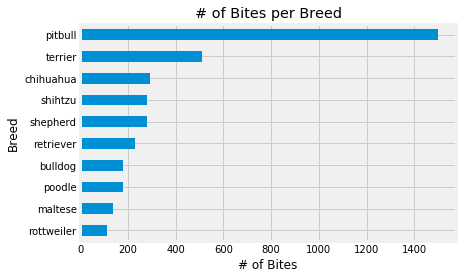

In [14]:
grouped_breeds = copy.groupby(
    by = 'general_breed'
).general_breed.count().sort_values()

plot = grouped_breeds[120:-1].plot(kind = 'barh')#exclude mixed breed

plot.set_title('# of Bites per Breed')

plot.set_xlabel('# of Bites')

plot.set_ylabel('Breed')

According to the bar graph, with the exception of 'mixed' breeds, reported bites from Pitbulls are the most common. Followed by: Terrier, Chihuahua, and Shitzus, close after. 

[]

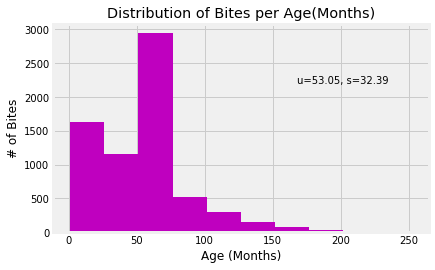

In [15]:
x = copy['age_in_months']

n_bins = 10 # of bins

fig, ax = plt.subplots()

fig.subplots_adjust(top = 0.85)

ax.hist(x, bins = n_bins, color = 'm')#creates histogram

ax.set_title('Distribution of Bites per Age(Months)')

ax.set_ylabel('# of Bites')

ax.set_xlabel('Age (Months)')

ax.text(168, 2200, 'u=53.05, s=32.39')

plt.plot()

The histogram shows the distribution of bites per age group. The distribution is right-skewed with the average age in months for reported dog bites being **53.05 months**. This distribution tells us that reported bites are more likely to be seen in dogs between **50 months** and **75 months**.

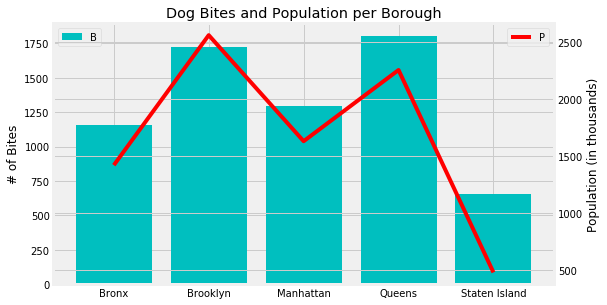

In [16]:
boroughs = ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']

dog_bites = [1158, 1722, 1295, 1805, 659 ]

population = [1418.207, 2559.903, 1628.706, 2253.858, 476.143]

fig, ax1 = plt.subplots(figsize = (8, 5))

fig.subplots_adjust(top = 0.85)

ax2 = ax1.twinx()  

ax1.bar(boroughs, dog_bites, color = 'c') 

ax2.plot(boroughs, population, color = 'red')

ax1.set_title('Dog Bites and Population per Borough')

ax1.set_ylabel('# of Bites')

ax2.set_ylabel('Population (in thousands)')

ax1.legend(labels = 'Bites',loc = 'upper left')

ax2.legend(labels = 'Population', loc = 'upper right')

plt.show()

When comparing the number of bites to populations per borough, it seems that bites are not disproportionate by boroughs. We can see that the number of bites fits relatively well with the line depicting population per borough.

(Population data taken from Cencus 2010)

Text(0.5, 0, 'Spay or Neutered')

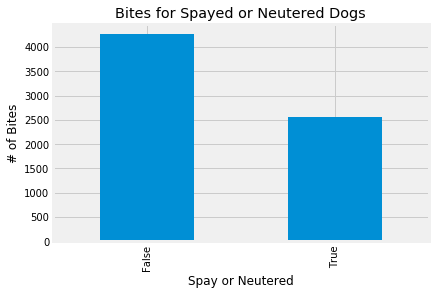

In [17]:
spay_plot = copy.spay_neuter.value_counts().plot(kind = 'bar')

spay_plot.set_title('Bites for Spayed or Neutered Dogs')

spay_plot.set_ylabel('# of Bites')

spay_plot.set_xlabel('Spay or Neutered')

It seems that dogs that are not spayed or neutered bite people nearly twice as much as dogs that are. Although other factors could be contributing to a dog's reason to bite a person, the plot is inline with sources which report:

          "getting your dog spayed or neutered can assist in reducing their desire to bite. For male dogs who have had this procedure, it reduces their testosterone levels which makes them less aggressive" (5 Tips to Stop Your Dog From Biting)

## Part 3. Conclusion

After completing the analysis, I have come to the following conclusions. A large number of dog bites are done by Pitbulls, with Terriers, Chihuahas and Shih Tzu's rounding out 2nd, 3rd, and 4th place, respectively. Younger dogs are more likely to bite than older dogs, with the mean age for dogs who have bitten being ~4.5 years. It seems that dog bites do not disproportionately effect certain boroughs. Dog bites are proportionate to population size in each borough. Finally, Dogs who are spayed or neutered are less likely to bite than dogs that are not. 

In order to curb the amount of dog bites, the following things can be done: Marketing campaigns can be produced by the city that encourage dog owners to register their dogs and provide owners with information on dog training, taking special attention to focus on owners with young Pitbulls, Terriers, Chihuahuas, and Shih Tzus. They can also encourage owners to spay or neuter their dogs, or start a program meant to subsidize surgeries for spay and neutering. These actions will cost a considerable amount of money, therefore it will be prudent to begin in Staten Island –which has the least number of bites– measure the success of the interventions, and expand them to the rest of city if interventions prove successful. 